Below, I install my own implementation of Professor Boonstra's "memoize DataFrame to disk" feature. The source code can be found at [github.com/ethho/memoize](https://github.com/ethho/memoize).

In [1]:
!python3 -m pip install git+https://github.com/ethho/memoize.git

  Cloning https://github.com/ethho/memoize.git to /tmp/pip-req-build-q2lrdvgz
  Running command git clone --filter=blob:none --quiet https://github.com/ethho/memoize.git /tmp/pip-req-build-q2lrdvgz
  Resolved https://github.com/ethho/memoize.git to commit bef633bd22e4acde44cccb63399a176c6cef79b9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [51]:
import json
import re
import os
from glob import glob
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import quandl
import functools
import plotly.express as px
import plotly.graph_objects as go
from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Pool
from src.ubacktester import (
    BacktestEngine, StrategyBase, PositionBase, FeedBase,
    PlotlyPlotter, FeedID, PriceFeed, px_plot
)
from memoize.dataframe import memoize_df

%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

# 20230126_hw3_ho_ethan_12350006

@mpcs
@finm33550

Ethan Ho 1/20/2023

----

Note to graders:

The scale of the data in this notebook is larger than we've seen in this class so far. Many of my processes below took minutes or even hours to run, due to the fact that they often needed to pull thousands of tickers from Quandl. For this reason, I have included the cached results of these expensive calls in the ZIP file. The `memoize_df` decorator should automatically recognize these files if they're in `./data/memoize/*.csv`, and use the result of the cached call instead. This should make the notebook much easier to grade.

## Configuration & Helper Functions

The following cell contains helper functions and configuration options that I will use in this notebook.

In [3]:
def get_secrets(fp='./secrets.json'):
    """
    Reads secret values such as API keys from a JSON-formatted file at `fp`.
    """
    with open(fp, 'r') as f:
        data = json.load(f)
    return data

def get_quandl_api_key() -> str:
    """
    Returns Quandl API key stored in secrets.json.
    """
    secrets = get_secrets()
    key = secrets.get('NASTAQ_DATA_API_KEY')
    assert key, f"NASTAQ_DATA_API_KEY field in secrets.json is empty or does not exist"
    return key

def strip_str_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame, strips values in columns with string or object
    dtype. I noticed that this was an issue when I saw some m_ticker values
    like "AAPL       " with trailing whitespace.
    """
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
            df[col] = df[col].str.strip()
    return df

@memoize_df(cache_dir='/tmp/memoize')
def fetch_quandl_quotemedia_prices(
    start_date, end_date, ticker
) -> pd.DataFrame:
    df = quandl.get_table(
        'QUOTEMEDIA/PRICES',
        date={'gte': start_date, 'lte': end_date},
        ticker=ticker,
        api_key=get_quandl_api_key(),
        paginate=True,
    )
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    return df

@memoize_df(cache_dir='/tmp/memoize')
def fetch_quandl_tbill_prices(
    start_date, end_date,
) -> pd.DataFrame:
    """Fetch table of treasury bill prices from Quandl."""
    df = quandl.get(
        ['USTREASURY/BILLRATES'],
        returns="pandas",
        start_date=start_date,
        end_date=end_date,
        ticker=ticker,
        api_key=get_quandl_api_key(),
    )
    df = df.reset_index().rename(columns={'Date': 'date'})
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    return df

def unique_index_keys(df, level=0) -> List[str]:
    return df.index.get_level_values(level=level).unique().tolist()

def risk_free_rate(**kw) -> float:
    """Calculates risk-free rate R_f from the 3-month T-bill rate."""
    tbill_prices = fetch_quandl_tbill_prices(**kw)
    tbill_returns = tbill_prices['USTREASURY/BILLRATES - 13 Wk Coupon Equiv']
    return tbill_returns.mean()

# Fetch Data Tables from Quandl

First, let's fetch the Zacks Fundmentals B. I chose to download zip archives as documented in the [Quandl API docs](https://github.com/quandl/quandl-python/blob/master/FOR_DEVELOPERS.md#datatable).

In [4]:
def fetch_zfb_table(table: str, include_cols: Optional[List] = None,
                    start_date: str = "2014-07-01", end_date: str = "2022-01-01") -> pd.DataFrame:
    table_lower = table.lower()
    zip_fp = f'data/zacks_{table.lower()}.zip'
    if os.path.isfile(zip_fp):
        print(f"Zip file {zip_fp} already exists. Skipping download")
    else:
        export_table_kwargs = dict(
            filename=zip_fp,
            api_key=get_quandl_api_key(),
        )
        if table not in ('MT', 'HDM'):
            export_table_kwargs['per_end_date'] = {
                'gte': start_date, 'lte': end_date
            }
        if include_cols:
            export_table_kwargs['qopts'] = {'columns': include_cols}
        fp = quandl.export_table(f'ZACKS/{table}',**export_table_kwargs)
        print(f"Wrote ZIP file to {zip_fp}")
    ! unzip -o -d data/zacks_{table_lower} {zip_fp}

    # DataFrame preprocessing
    df = pd.read_csv(*glob(f'data/zacks_{table_lower}/*.csv'))
    df = strip_str_dtypes(df)

    # Set MultiIndex of date and m_ticker
    if 'per_end_date' in df.columns:
        assert 'per_type' in df.columns, f'per_type does not exist in {table=}'
        df['per_end_date'] = pd.to_datetime(df['per_end_date'])
        df.set_index(['m_ticker', 'per_end_date', 'per_type'], inplace=True)
        df.sort_index(level=(0, 1, 2), inplace=True, ascending=(True, True, False))
    else:
        df.set_index('m_ticker', inplace=True)
        df.sort_index(inplace=True)
    
    return df

In [5]:
! mkdir -p data

fc = fetch_zfb_table('FC', include_cols=[
    'ticker',
    'm_ticker',
    'per_end_date',
    'per_type',
    'filing_date',
    'zacks_x_ind_code',
    'zacks_sector_code',
    'eps_diluted_net',
    'basic_net_eps',
    'net_lterm_debt',
    'tot_lterm_debt',
])

fr = fetch_zfb_table('FR', include_cols=[
    'ticker',
    'm_ticker',
    'per_end_date',
    'per_type',
    'ret_invst',
    'tot_debt_tot_equity',
    'profit_margin',
])

# fetch_zfb_table('MT', include_cols=[])

# fetch_zfb_table('HDM', include_cols=[])

mktv = fetch_zfb_table('MKTV', include_cols=[
    'ticker',
    'm_ticker',
    'per_end_date',
    'per_type',
    'mkt_val',
])

shrs = fetch_zfb_table('SHRS', include_cols=[
    'ticker',
    'm_ticker',
    'per_end_date',
    'per_type',
    'shares_out',
])

Zip file data/zacks_fc.zip already exists. Skipping download
Archive:  data/zacks_fc.zip
  inflating: data/zacks_fc/ZACKS_FC_2_0d6bd1d0f1e9e9f3f7f17a9212664633.csv  
Zip file data/zacks_fr.zip already exists. Skipping download
Archive:  data/zacks_fr.zip
  inflating: data/zacks_fr/ZACKS_FR_2_21b9fd416a9137b052509d8259f53e5b.csv  
Zip file data/zacks_mktv.zip already exists. Skipping download
Archive:  data/zacks_mktv.zip
  inflating: data/zacks_mktv/ZACKS_MKTV_2_0920177720004cb378c3b2aead9f7622.csv  
Zip file data/zacks_shrs.zip already exists. Skipping download
Archive:  data/zacks_shrs.zip
  inflating: data/zacks_shrs/ZACKS_SHRS_2_01ee4c4e8e147a957fd5a98ccaf5cf0a.csv  


The next command will check file sizes, to make sure that we're not occupying too much disk space on graders' machines.

In [6]:
! du -hs data/zacks_*

16M	data/zacks_fc
3.6M	data/zacks_fc.zip
12M	data/zacks_fr
3.5M	data/zacks_fr.zip
14M	data/zacks_mktv
2.0M	data/zacks_mktv.zip
14M	data/zacks_shrs
1.7M	data/zacks_shrs.zip


# From HW 3 Prompt

Find $\ge$ 200 tickers where the following conditions are met for our analysis period of 1/2015 - 1/2022:

- Not in automotive, financial, or insurance sector at any point in the period
    - See `FC/ZACKS_X_IND_CODE`, `FC/ZACKS_SECTOR_CODE`, and the [classification list](http://www.zacksdata.com/app/download/247340904/Zacks+Sector+Industry+Mapping+Scheme.pdf) (and maybe `FC/ZACKS_METRICS_IND_CODE` too?)
- Debt/market cap ratio is $>0.1$ for some nontrivial amount of time. Should be about 1000-2000 companies including ASH, VTOL, ISUN, and VIVO.
- Calculation of the following ratios is feasible:
    - Debt to market cap
        - See `FR/TOT_DEBT_TOT_EQUITY`
    - Return on investment (ROI)
        - See `FR/RET_INVST`, `MKTV/MKT_VAL`, `FC/NET_LTERM_DEBT`, `FC/TOT_LTERM_DEBT`
    - Price to earnings (P/E)
        - See `FC/EPS_DILUTED_NET`, `FC/BASIC_NET_EPS`, `SHRS/SHARES_OUT`, `MKTV/MKT_VAL`, `GAAP`
        
# Data Munging to Get List of Tickers

From the FC table, let's filter out tickers in the excluded sectors. By the way, most of the time, when I refer to ticker, I'm actually referring to the `m_ticker`, which is easier to track historically as securities switch between exchanges.

In [7]:
fc['zacks_sector_code'] = fc['zacks_sector_code'].fillna(-1.).astype(int)
fc['zacks_x_ind_code'] = fc['zacks_x_ind_code'].fillna(-1.).astype(int)
fc.head()

ticker filing_date  zacks_x_ind_code  \
m_ticker per_end_date per_type                                        
NaN      2014-07-31   Q          T.NA         NaN                12   
         2014-10-31   Q          T.NA         NaN                12   
                      A          T.NA         NaN                12   
         2015-01-31   Q          T.NA         NaN                12   
         2015-04-30   Q          T.NA         NaN                12   

                                zacks_sector_code  eps_diluted_net  \
m_ticker per_end_date per_type                                       
NaN      2014-07-31   Q                        13              NaN   
         2014-10-31   Q                        13              NaN   
                      A                        13              NaN   
         2015-01-31   Q                        13              NaN   
         2015-04-30   Q                        13              NaN   

                                basic_net_eps  net_lterm_debt  tot_lterm_debt  
m_ticker per_end_date per_type                                                 
NaN      2014-07-31   Q                   NaN             NaN             NaN  
         2014-10-31   Q                   NaN             NaN             NaN  
                      A                   NaN             NaN             NaN  
         2015-01-31   Q                   NaN             NaN             NaN  
         2015-04-30   Q                   NaN             NaN             NaN

We define which sectors we want to filter out for each column:

In [8]:
exclude_codes_spec = {
    'zacks_sector_code': (
        5, # automotive
        13, # finance
    ),
    'zacks_x_ind_code': [
        7, 8, 9, 10, 11, 210, # automotive
        *range(61, 70), # finance
        *range(85, 90), # insurance
    ]
}

In [9]:
print(f"There are {fc.index.get_level_values(0).unique().size} unique tickers before sector filtering.")

There are 11985 unique tickers before sector filtering.


We'll define a boolean mask and use it to get the list of `m_ticker`s we want to exclude.

In [10]:
fc['exclude_sector'] = (
    fc['zacks_sector_code'].isin(exclude_codes_spec['zacks_sector_code']) |
    fc['zacks_x_ind_code'].isin(exclude_codes_spec['zacks_x_ind_code'])
)
exclude_sector = fc[fc['exclude_sector']].index.get_level_values(0).unique().tolist()
exclude_sector[:10]

[nan, '#AQN', '#AVT', '#AZL', '#BLR', '#CED', '#EXH', '#FCO', '#FRP', '#INT']

In [11]:
fc.drop(index=exclude_sector, inplace=True, errors='ignore')
print(f"There are {len(exclude_sector)} tickers that are excluded due to sector.")

There are 2210 tickers that are excluded due to sector.


We removed about $\frac{1}{5}$ of the tickers with this filter.

Next, we'll filter to tickers where debt/market cap $> 1$, and where the last `per_end_date` was more than a year ago:

In [12]:
low_debt2cap_mask = (
    fr
    .groupby(level=0, group_keys=False)
    .apply(
        lambda x:
        # debt/equity was not greater than 0.1 for
        # more than one date
        not ((x['tot_debt_tot_equity'] > 0.1).sum() > 1)
    )
)
low_debt2cap = low_debt2cap_mask[low_debt2cap_mask].index.tolist()
print(f"{len(low_debt2cap)} tickers have debt/market cap ratio below threshold.")

3902 tickers have debt/market cap ratio below threshold.


In [13]:
no_recent_filing_mask = (
    fc
    .groupby(level=0)
    .apply(
        lambda x:
        pd.to_datetime('2022-01-01') - x.index.get_level_values(1)[-1]
        > pd.to_timedelta(365, 'D')
    )
)
no_recent_filing = no_recent_filing_mask[no_recent_filing_mask].index.tolist()
print(f"{len(no_recent_filing)} tickers have no filing on record in the past year.")

2956 tickers have no filing on record in the past year.


Now, use the lists of excluded `m_ticker`s calculated above to remove these rows from all tables:

In [14]:
fr.drop(index=low_debt2cap, inplace=True, errors='ignore')
fr.drop(index=exclude_sector, inplace=True, errors='ignore')
fr.drop(index=no_recent_filing, inplace=True, errors='ignore')
fc.drop(index=low_debt2cap, inplace=True, errors='ignore')
fc.drop(index=exclude_sector, inplace=True, errors='ignore')
fc.drop(index=no_recent_filing, inplace=True, errors='ignore')
mktv.drop(index=low_debt2cap, inplace=True, errors='ignore')
mktv.drop(index=exclude_sector, inplace=True, errors='ignore')
mktv.drop(index=no_recent_filing, inplace=True, errors='ignore')
shrs.drop(index=low_debt2cap, inplace=True, errors='ignore')
shrs.drop(index=exclude_sector, inplace=True, errors='ignore')
shrs.drop(index=no_recent_filing, inplace=True, errors='ignore')

At this point, we've filtered our data enough to merge all the data tables into one DataFrame without running out of memory. Since all our tables are already indexed on m_ticker, per_end_date, and per_type, we can simply merge them on the MultiIndex.

In [15]:
filings_df = (
    fc
    .merge(fr,   how='left', left_index=True, right_index=True, suffixes=('_fc', '_fr'))
    .merge(mktv, how='left', left_index=True, right_index=True, suffixes=(None, '_mktv'))
    .merge(shrs, how='left', left_index=True, right_index=True, suffixes=(None, '_shrs'))
)
filings_df['filing_date'] = pd.to_datetime(filings_df['filing_date'])
print(f"{len(unique_index_keys(filings_df))} tickers in the filings DataFrame.")

4626 tickers in the filings DataFrame.


The next step is calculating our financial ratios, which requires daily price data. We'll first fetch QuoteMedia prices like we did in HW 2.

Since QuoteMedia prices are indexed by `ticker`, not `m_ticker`, we need to be careful about possible duplicate `ticker` values. I suspect there are few to none of these, but let's check.

In [16]:
filings_df['ticker'] = filings_df['ticker_fr']
assert not filings_df['ticker'].isnull().any()
assert not filings_df.groupby(level=0).apply(lambda x: x['ticker'].unique()[0]).duplicated().any()

It seems that for our dataset, `m_ticker` maps 1:1 to `ticker`, so we can safely re-index on `ticker`:

In [17]:
filings_df = (
    filings_df
    .reset_index()
    .set_index(['ticker', 'per_end_date'])
    .drop(columns=[
        'm_ticker', 'ticker_fc', 'ticker_fr', 
        'zacks_x_ind_code', 'zacks_sector_code', 
        'exclude_sector', 'ticker_shrs'], errors='ignore')
)
filings_df

per_type filing_date  eps_diluted_net  basic_net_eps  \
ticker per_end_date                                                        
ABLT   2014-12-31          A  2014-12-31          91.4700        87.4710   
       2015-12-31          A  2015-12-31         -22.2000       -21.2060   
       2016-12-31          A  2016-12-31          38.9300        37.2060   
       2017-12-31          A  2017-12-31         152.5200       145.9710   
       2018-09-30          Q         NaT          27.1000            NaN   
...                      ...         ...              ...            ...   
ZYXI   2021-03-31          Q  2021-04-29          -0.0200        -0.0182   
       2021-06-30          Q  2021-07-29           0.0700         0.0727   
       2021-09-30          Q  2021-11-02           0.1600         0.1636   
       2021-12-31          Q  2022-03-22           0.2300         0.2300   
       2021-12-31          A  2022-03-22           0.4400         0.4500   

                     net_lterm_debt  tot_lterm_debt  ret_invst  \
ticker per_end_date                                              
ABLT   2014-12-31           -1.4780          5.9900     7.5765   
       2015-12-31           -1.5650          4.4210    -2.0765   
       2016-12-31           -5.6510          0.1220     3.7844   
       2017-12-31            0.0850          0.2490    13.3385   
       2018-09-30            0.2510             NaN        NaN   
...                             ...             ...        ...   
ZYXI   2021-03-31           -0.0230          0.3970    -1.2485   
       2021-06-30           -0.0440          0.3710     4.8690   
       2021-09-30           -0.0730          0.3470     9.5826   
       2021-12-31           -0.0980         10.9220    10.4824   
       2021-12-31           -0.0980         10.9220    20.1575   

                     tot_debt_tot_equity  profit_margin  mkt_val  shares_out  
ticker per_end_date                                                           
ABLT   2014-12-31                 0.3607         1.4466      NaN         NaN  
       2015-12-31                 0.2883        -0.3700      NaN         NaN  
       2016-12-31                 0.0621         0.6865      NaN         NaN  
       2017-12-31                 0.1020         2.4749      NaN         NaN  
       2018-09-30                    NaN         1.7837  16.5600      0.0300  
...                                  ...            ...      ...         ...  
ZYXI   2021-03-31                 0.0089        -2.9262      NaN         NaN  
       2021-06-30                 0.0083         9.0516      NaN         NaN  
       2021-09-30                 0.0073        17.5559      NaN         NaN  
       2021-12-31                 0.2215        22.0334      NaN         NaN  
       2021-12-31                 0.2215        13.1258      NaN         NaN  

[145327 rows x 11 columns]

In [18]:
def get_daily_adj_close(ticker: str, start_date='2014-07-01', end_date='2022-01-01') -> pd.Series:
    """
    Gets adjusted closing prices for `ticker`.
    
    NOTE: this method ffills price so that the index includes every calendar day.
    """
    df_raw = fetch_quandl_quotemedia_prices(
        start_date=start_date,
        end_date=end_date,
        ticker=ticker,
    )
    df_raw['date'] = pd.to_datetime(df_raw['date'])
    df_raw.sort_values(by='date', ascending=True, inplace=True)
    day_idx = pd.date_range(
        pd.to_datetime(start_date) + pd.to_timedelta(1, 'D'),
        end_date
    )
    df = (
        df_raw
        .set_index('date')
        [['adj_close']]
        .reindex(day_idx, method='ffill')
        .reset_index()
        .rename(columns=dict(index='date'))
    )
    
    return df

In [19]:
def calc_roi(row, filing_row):
    """
    Calculate ROI based on current row
    and a row containing figures from the last known filing.
    """
    if filing_row is None:
        return float('nan')
    if pd.isnull(getattr(filing_row, 'adj_close', None)):
        return float('nan')
    mkt_val = filing_row.mkt_val * row.adj_close / filing_row.adj_close
    
    # Calculate debt term, prioritizing net over total
    # and more recent over date of filing
    filing_debt = None
    if not pd.isnull(filing_row.net_lterm_debt):
        filing_debt = filing_row.net_lterm_debt 
    elif not pd.isnull(filing_row.tot_lterm_debt):
        filing_debt = filing_row.net_lterm_debt 
    filing_debt = filing_debt if filing_debt and not pd.isnull(filing_debt) else 0.
    debt_vals = [
        row.net_lterm_debt,
        row.tot_lterm_debt,
        filing_debt
    ]
    for val in debt_vals:
        if not pd.isnull(val) and val:
            debt = val
            break
    else:
        debt = 0.
    
    # Calculate the "return" R for the report date
    returns = filing_row.ret_invst * (filing_debt + filing_row.mkt_val)
        
    roi = returns / (debt + mkt_val)
    return roi


def calc_pe(row, filing_row):
    """
    Calculate P/E based on current row
    and a row containing figures from the last known filing.
    
    mkt_val per share / EPS
    """
    if filing_row is None:
        return float('nan')
    if pd.isnull(getattr(filing_row, 'adj_close', None)):
        return float('nan')
    
    eps = row.eps_diluted_net if not pd.isnull(row.eps_diluted_net) else row.basic_net_eps
    mkt_val = filing_row.mkt_val * row.adj_close / filing_row.adj_close
    if not row.shares_out or not eps:
        return 0.001
    vps = mkt_val / row.shares_out
    per = vps / eps
    if per < 0.:
        per = 0.001
    return per

def get_fin_ratios(in_df: pd.DataFrame, start_date='2015-01-01') -> pd.DataFrame:
    """
    Given a DataFrame for a single ticker containing only filings data,
    indexed by `per_end_date`, calculate the following ratios, 
    accounting for missing and lagged data streams:
    
    - Debt/market cap
    - ROI
    - P/E
    """
    # Fetch price data
    # tickers = in_df.ticker.unique().tolist()
    tickers = unique_index_keys(in_df)
    assert len(tickers) == 1, f"expected only a single ticker: {tickers=}"
    ticker = tickers[0]
    prices = get_daily_adj_close(ticker=ticker)
    
    df = pd.merge(prices, in_df.reset_index(), how='left', left_on='date', right_on='filing_date')
    df = df.set_index(['date', 'per_type'])
    df = df.sort_index()
    df['filing_date'] = df['filing_date'].ffill()
    df['roi'] = float('nan')
    df['pe'] = float('nan')
    df['ticker'] = ticker
    if prices['adj_close'].loc[start_date:].isnull().any():
        # Exit if any adjusted closing price is
        # not available
        return df
    
    prev_q = None
    prev_a = None
    for idx, row in df.iterrows():
        date, per_type = idx
        if pd.isnull(row.filing_date):
            continue
            # pass
        if per_type == 'Q':
            # print('filing Q', date, row)
            prev_q = row
        elif per_type == 'A':
            # print('filing A', date, row)
            prev_a = row
        elif pd.isnull(per_type):
            pass
        else:
            raise NotImplementedError(f"unsupported {per_type=}")
        assert date >= row.filing_date, (date, row.filing_date)
        
        if date < pd.to_datetime(start_date):
            continue
        
        # fillna with previous values if necessary
        for attr_name in (
            'tot_debt_tot_equity',
            'eps_diluted_net',
            'basic_net_eps',
            'net_lterm_debt',
            'tot_lterm_debt',
            'ret_invst',
            'mkt_val',
            'shares_out',
            'profit_margin',
        ):
            prev_a_attr = getattr(prev_a, attr_name, None)
            prev_q_attr = getattr(prev_q, attr_name, None)
            attr = getattr(row, attr_name, None)
            if pd.isnull(attr):
                if not pd.isnull(prev_q_attr):
                    setattr(row, attr_name, prev_q_attr)
                    # print('setattr Q', date, attr, prev_q_attr)
                elif not pd.isnull(prev_a_attr):
                    setattr(row, attr_name, prev_a_attr)
                    # print('setattr A', date, attr, prev_a_attr)
                    
        # Calculate ROI based on backfilled data
        row.roi = calc_roi(row, prev_q)
        if pd.isnull(row.roi):
            # Try last annual filing if quarterly data did not work
            row.roi = calc_roi(row, prev_a)
            # print('roi A')
        else:
            # print('roi Q')
            pass
        
        # Calculate P/E 
        row.pe = calc_pe(row, prev_q)
        if pd.isnull(row.pe):
            # Try last annual filing if quarterly data did not work
            row.pe = calc_pe(row, prev_a)
        
        try:
            df.loc[idx, :] = row
        except ValueError as err:
            if 'Must have equal len keys and value when setting with an iterable' not in str(err):
                raise
            df.loc[idx, :] = [row] * len(df.loc[idx, :])
        # print(row.roi)
        # print(df.loc[idx, 'roi'])
        # assert not pd.isnull(row.roi)
            
    return df.loc[start_date:]

The above functions perform the necessary logic to calculate financial ratios for each ticker, taking into account the fallback logic for missing data.

As my fourth financial ratio, I've chosen net profit margin, which is the ratio of income to revenue for the time period.

#### Note on Performance

I could not find a good way to make the above process take less than an hour without running OOM, while also implementing the nuanced fallback logic and also making the code readable. I did parallelize the process so that multiple tickers can be processed simultaneously. My argument is that this does not significantly impact the usability of this opportunity, since a strategy trading every week or month can definitely afford to spend an hour of computation time generating this DataFrame.

Since this function takes multiple hours, I've included the output of `get_all_fin_ratios` as a CSV file with my homework submission, for the purposes of grading. The code will automatically detect the CSV file and avoid re-running this lengthy process. 

In [20]:
def temp_func(func, name, group):
    return func(group), name

def applyParallel(dfGrouped, func):
    """
    Parallelizes GroupBy.apply.
    Adapted from https://stackoverflow.com/questions/39284989/parallelize-pandas-apply
    """
    retLst, top_index = zip(*Parallel(n_jobs=multiprocessing.cpu_count())(delayed(temp_func)(func, name, group) for name, group in dfGrouped))
    return pd.concat(retLst, keys=top_index)

@memoize_df(cache_dir='./data/memoize')
def get_all_fin_ratios(tickers=None) -> pd.DataFrame:
    if not tickers:
        groups = filings_df.groupby(level=0, group_keys=True)
    else:
        groups = filings_df.loc[(tickers, slice(None)), slice(None)].groupby(level=0, group_keys=True)
    return applyParallel(groups, get_fin_ratios).reset_index()

In [21]:
%%time

df = (
    get_all_fin_ratios(tickers=None)
    # get_all_fin_ratios(tickers=['ASH', 'VTOL', 'ISUN', 'VIVO'])
    .set_index(['level_0', 'date'])
    .sort_index()
)

Using cache fp='./data/memoize/get_all_fin_ratios_556db19_20230126.csv' to write results of function get_all_fin_ratios
Using cached call from ./data/memoize/get_all_fin_ratios_556db19_20230126.csv


/home/eho/miniconda3/envs/quant/lib/python3.10/site-packages/memoize/dataframe.py:20: DtypeWarning: Columns (2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(fp)


CPU times: user 18.1 s, sys: 5.15 s, total: 23.3 s
Wall time: 24.6 s


We can see using the `top` command that the above process is using 8 threads:

```
top - 11:32:09 up 20 min,  0 users,  load average: 6.19, 2.24, 0.90
Tasks:  38 total,  10 running,  28 sleeping,   0 stopped,   0 zombie
%Cpu(s): 99.6 us,  0.3 sy,  0.0 ni,  0.0 id,  0.0 wa,  0.0 hi,  0.1 si,  0.0 st
MiB Mem :   7949.0 total,   4870.5 free,   1821.5 used,   1257.1 buff/cache
MiB Swap:   2048.0 total,   2048.0 free,      0.0 used.   5833.2 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU  %MEM     TIME+ COMMAND                                                                                                                                 
 3338 eho       20   0  284936 124976  51340 R 100.3   1.5   1:24.21 python                                                                                                                                  
 3339 eho       20   0  286160 124748  51140 R 100.3   1.5   1:24.02 python                                                                                                                                  
 3333 eho       20   0  286028 125180  51076 R 100.0   1.5   1:24.27 python                                                                                                                                  
 3335 eho       20   0  286084 124964  51252 R 100.0   1.5   1:24.25 python                                                                                                                                  
 3337 eho       20   0  285396 127380  51280 R  99.7   1.6   1:24.17 python                                                                                                                                  
 3332 eho       20   0  286228 125544  51632 R  99.3   1.5   1:24.03 python                                                                                                                                  
 3334 eho       20   0  286012 127076  51596 R  98.7   1.6   1:24.28 python                                                                                                                                  
 3336 eho       20   0  286372 124976  51220 R  96.7   1.5   1:23.84 python 
 ```

Let's check the example tickers from the homework prompt. I'll check how many null ROI values exist for each ticker.

In [22]:
df.groupby(level=0).apply(lambda x: x['roi'].isnull().sum())

level_0
A        2565
AA        805
AAC      2328
AACAY    2741
AACG     2558
         ... 
ZTS         0
ZUO      2561
ZWS         0
ZY       2741
ZYXI     2565
Length: 4626, dtype: int64

We can see that ISUN has a number of null ROI values; let's check its filings data to investigate:

In [23]:
filings_df.loc['ISUN'].head()

,per_type,filing_date,eps_diluted_net,basic_net_eps,net_lterm_debt,tot_lterm_debt,ret_invst,tot_debt_tot_equity,profit_margin,mkt_val,shares_out
per_end_date,,,,,,,,,,,
2014-12-31,Q,NaT,NaN,NaN,NaN,0.1100,NaN,NaN,NaN,NaN,NaN
2014-12-31,A,NaT,NaN,NaN,NaN,0.1160,NaN,-2.1559,NaN,NaN,NaN
2015-03-31,Q,NaT,-0.0200,NaN,0.0395,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,Q,NaT,-0.0300,NaN,0.0983,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,Q,NaT,-0.0100,NaN,0.1383,NaN,NaN,NaN,NaN,NaN,NaN


Although there were both quarterly and annual reports filed before our start date 2015-01-01, they're missing `mkt_val` data. So we'll have to exclude this ticker since we cannot calculate financial ratios for all tickers.

Below, I remove tickers where any of the financials are null at any point:

In [24]:
null_financials_mask = (
    df
    .groupby(level=0)
    .apply(
        lambda x:
        x[['tot_debt_tot_equity', 'roi', 'pe']].isnull().any().any()
    )
)
null_financials = null_financials_mask[null_financials_mask].index.tolist()
print(f"{len(null_financials)} tickers have some null value for at least one financial ratio.")
df.drop(index=null_financials, inplace=True, errors='ignore')
print(f"{len(unique_index_keys(df))} tickers left in the DataFrame")

3256 tickers have some null value for at least one financial ratio.
1370 tickers left in the DataFrame


Next, we'll write a function that fetches the top $N$ tickers and bottom $N$ tickers for a column.

In [25]:
def get_quantiles(in_df, by='roi', n=5):
    ratio = by

    def get_ranked_for_date(in_df):
        df = in_df.sort_values(ratio, ascending=False)
        top_n = df['ticker'].iloc[:n].tolist()
        bot_n = df['ticker'].iloc[::-1].iloc[:n].tolist()
        return (top_n, bot_n)

    def get_ratio_ranked(in_df):
        ratio_ranked = in_df.groupby('date')[['ticker', ratio]].apply(get_ranked_for_date)
        return ratio_ranked

    return get_ratio_ranked(in_df)
    
df_no_idx = df.reset_index().drop(columns=['level_0']).sort_values(by='date')
quantiles_roi = get_quantiles(df_no_idx, by='roi', n=5)
quantiles_roi

date
2015-01-01    ([NSPR, XOMA, NAVB, APDN, SIGA], [CASI, OMER, ...
2015-01-02    ([NSPR, XOMA, NAVB, APDN, SIGA], [CASI, OMER, ...
2015-01-03    ([NSPR, XOMA, NAVB, APDN, SIGA], [CASI, OMER, ...
2015-01-04    ([NSPR, XOMA, NAVB, APDN, SIGA], [CASI, OMER, ...
2015-01-05    ([NSPR, XOMA, NAVB, APDN, SIGA], [CASI, OMER, ...
                                    ...                        
2021-12-28    ([AGEN, PALI, MARK, AMRS, MTMT], [ERNA, TUP, A...
2021-12-29    ([AGEN, PALI, MARK, AMRS, MTMT], [ERNA, TUP, A...
2021-12-30    ([AGEN, PALI, MARK, AMRS, MTMT], [ERNA, TUP, S...
2021-12-31    ([AGEN, PALI, MARK, AMRS, MTMT], [ERNA, TUP, S...
2022-01-01    ([AGEN, PALI, MARK, AMRS, MTMT], [ERNA, TUP, S...
Length: 2558, dtype: object

Let's check that our function's results are intuitive:

In [26]:
df_no_idx[['date', 'ticker', 'roi']][df_no_idx.ticker == 'NSPR'].head()

,date,ticker,roi
2210897,2015-01-01,NSPR,"2,834.6328"
2210898,2015-01-02,NSPR,"2,761.7071"
2210899,2015-01-03,NSPR,"2,761.7071"
2210900,2015-01-04,NSPR,"2,761.7071"
2210901,2015-01-05,NSPR,"2,825.4894"


In [27]:
df_no_idx[['date', 'ticker', 'roi']][df_no_idx.ticker == 'ERNA'].tail()

,date,ticker,roi
1066972,2021-12-28,ERNA,"-1,013.1945"
1066973,2021-12-29,ERNA,"-1,072.5019"
1066974,2021-12-30,ERNA,"-1,090.3730"
1066975,2021-12-31,ERNA,"-1,100.8549"
1066976,2022-01-01,ERNA,"-1,100.8549"


We now calculate the top and bottom 5 for each financial ratio at each timepoint and assemble into a DataFrame:

In [28]:
quantiles = pd.DataFrame(
    data=quantiles_roi.values.tolist(), 
    index=quantiles_roi.index,
    columns=['roi_top', 'roi_bot'])
quantiles

,roi_top,roi_bot
date,,
2015-01-01,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, VIRX]"
2015-01-02,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]"
2015-01-03,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]"
2015-01-04,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]"
2015-01-05,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, VIRX]"
...,...,...
2021-12-28,"[AGEN, PALI, MARK, AMRS, MTMT]","[ERNA, TUP, AGRX, OMER, SNMP]"
2021-12-29,"[AGEN, PALI, MARK, AMRS, MTMT]","[ERNA, TUP, AGRX, OMER, AEHL]"
2021-12-30,"[AGEN, PALI, MARK, AMRS, MTMT]","[ERNA, TUP, SNMP, AGRX, OMER]"


In [29]:
all_ranked = list()
all_ranked.extend(quantiles[f'roi_bot'].explode().unique().tolist())
all_ranked.extend(quantiles[f'roi_top'].explode().unique().tolist())

for ratio in ('tot_debt_tot_equity', 'pe', 'profit_margin'):
    quantiles_ratio = get_quantiles(df_no_idx, by=ratio, n=5)
    as_df = pd.DataFrame(
        data=quantiles_ratio.values.tolist(), 
        index=quantiles_ratio.index,
        columns=[f'{ratio}_top', f'{ratio}_bot']
    )
    quantiles = quantiles.join(as_df)
    all_ranked.extend(quantiles[f'{ratio}_bot'].explode().unique().tolist())
    all_ranked.extend(quantiles[f'{ratio}_top'].explode().unique().tolist())

We keep track of the list of tickers that are ever ranked in the top or bottom quantile:

In [30]:
len(np.unique(all_ranked))

1128

In [31]:
len(unique_index_keys(df))

1370

In [32]:
quantiles.head()

,roi_top,roi_bot,tot_debt_tot_equity_top,tot_debt_tot_equity_bot,pe_top,pe_bot,profit_margin_top,profit_margin_bot
date,,,,,,,,
2015-01-01,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, VIRX]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[AWH, ACHV, ACFN, APYX, SYPR]","[EMR, CREG, GSAT, LEU, MIC]","[EXAS, FLXN, FATE, FBIO, DARE]"
2015-01-02,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[SOFO, NOW, SPPI, UUU, LXRX]","[EMR, CREG, GSAT, LEU, MIC]","[DARE, ALDX, CASI, TTOO, ADMP]"
2015-01-03,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[NEO, IGC, IVC, APA, KN]","[EMR, CREG, GSAT, LEU, MIC]","[TTOO, TRVN, SLS, TSAT, CLVSQ]"
2015-01-04,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[VRTX, LPX, FRO, DARE, TMX]","[EMR, CREG, GSAT, LEU, MIC]","[AERI, HRTX, AGRX, RDUS, INSM]"
2015-01-05,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, VIRX]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[QUIK, CCLP, TSAT, SCOR, CCOI]","[EMR, CREG, GSAT, LEU, MIC]","[GNCAQ, CLRB, CLVSQ, NVIV, TTOO]"


# Backtest a Quantile Strategy


Here, we'll define a quantile strategy using my backtest engine that I wrote for HW2. Unfortunately, the backtest engine's performance is slow for this particular shape of data (many columns), so I had to make some modifications to how I used the framework. In particular, I parallelized the slow backtesting process and cached the results in CSV files that I then concatenated.

In [43]:
prices = (
    df['adj_close']
    .reset_index()
    .pivot_table(index='date', columns='level_0', values='adj_close', aggfunc='median')
    # .reset_index()
    [np.unique(all_ranked).tolist()]
)
prices.head()

level_0,AAL,AAOI,AAWW,ABBV,ABC,ABEO,ABT,ACCO,ACFN,ACHC,...,XPO,XRAY,XRX,YUM,ZBH,ZD,ZEN,ZEUS,ZGNX,ZWS
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,50.8071,11.2200,49.3000,46.1730,79.3851,86.2500,38.5431,7.6913,0.7710,61.2100,...,24.1767,50.0758,28.0581,44.9307,106.4737,56.7704,24.3700,16.9829,10.9600,27.5585
2015-01-02,51.0723,10.7900,48.4200,46.4905,79.6492,85.0000,38.4404,7.5035,0.7700,59.9800,...,24.0288,48.8162,27.8354,44.6223,105.6945,56.0837,24.5700,17.4604,11.3600,27.2947
2015-01-03,51.0723,10.7900,48.4200,46.4905,79.6492,85.0000,38.4404,7.5035,0.7700,59.9800,...,24.0288,48.8162,27.8354,44.6223,105.6945,56.0837,24.5700,17.4604,11.3600,27.2947
2015-01-04,51.0723,10.7900,48.4200,46.4905,79.6492,85.0000,38.4404,7.5035,0.7700,59.9800,...,24.0288,48.8162,27.8354,44.6223,105.6945,56.0837,24.5700,17.4604,11.3600,27.2947
2015-01-05,51.0392,10.6500,46.6500,45.6156,78.9713,80.2500,38.4490,7.3584,0.7800,59.1200,...,23.2836,48.4777,27.2281,43.7156,109.6373,55.1772,24.0600,15.8558,11.2000,26.2103


In [72]:
@dataclass
class NaiveQuantileStrat(StrategyBase):
    # Proportion of cash_equity
    # to place on all positions
    gross_traded_pct: float = 0.1 
    # Which financial ratio to use
    ratio: str = 'roi'
    
    def buy_top_n(self, pos_size, ratio='roi'):
        tickers = getattr(self.feeds['quantiles'], f'{ratio}_top')
        for ticker in tickers:
            self.buy(
                symbol=ticker,
                pos_size=pos_size / len(tickers),
                feed_id=('prices', ticker),
                close_opposite=False,
                allow_fractional=True,
            )
    
    def sell_bot_n(self, pos_size, ratio='roi'):
        tickers = getattr(self.feeds['quantiles'], f'{ratio}_bot')
        for ticker in tickers:
            self.sell(
                symbol=ticker,
                pos_size=pos_size / len(tickers),
                feed_id=('prices', ticker),
                close_opposite=False,
                allow_fractional=True,
            )
            
    def start(self):
        self.starting_cash_equity = self.cash_equity

    def step(self):
        # If not Monday, skip
        if not pd.to_datetime(self.dt).day_of_week == 0:
            return
        
        # Close all positions
        self.exit_all()
        
        # Open new set of positions
        gross_traded_cash = self.gross_traded_pct * self.starting_cash_equity
        self.buy_top_n(pos_size=gross_traded_cash/2., ratio=self.ratio)
        self.sell_bot_n(pos_size=gross_traded_cash/2., ratio=self.ratio)

In [73]:
date_ranges = (
    ('2015-01-01', '2015-12-31'),
    ('2016-01-01', '2016-12-31'),
    ('2017-01-01', '2017-12-31'),
    ('2018-01-01', '2018-12-31'),
    ('2019-01-01', '2019-12-31'),
    ('2020-01-01', '2020-12-31'),
    ('2021-01-01', '2021-12-31'),
)

In [112]:
@memoize_df(cache_dir='./data/memoize')
def run_quantile_strat(ratio, start_date, end_date) -> pd.DataFrame:
    be = BacktestEngine(
        start_date=start_date,
        end_date=end_date,
    )
    quantiles_feed = PriceFeed.from_df(quantiles.loc[start_date:end_date])
    prices_feed = PriceFeed.from_df(prices.loc[start_date:end_date].reset_index())
    be.add_feed(quantiles_feed, name='quantiles')
    be.add_feed(prices_feed, name='prices')
    strat = NaiveQuantileStrat(cash_equity=1e4, ratio=ratio)
    strat.name = ratio
    be.add_strategy(strat)
    be.run()
    return strat.df.reset_index()

In [113]:
def pe_runner_wrapper(date_range):
    return run_quantile_strat('pe', *date_range) 

def run_quantile_strat_pe():
    with Pool() as p:
        results_agg = p.map(pe_runner_wrapper, date_ranges)
    return results_agg

In [114]:
%%time
results_agg = run_quantile_strat_pe()

Using cache fp='./data/memoize/run_quantile_strat_71f8458_20230126.csv' to write results of function run_quantile_stratUsing cache fp='./data/memoize/run_quantile_strat_0c09f4b_20230126.csv' to write results of function run_quantile_stratUsing cache fp='./data/memoize/run_quantile_strat_63e5afc_20230126.csv' to write results of function run_quantile_stratUsing cache fp='./data/memoize/run_quantile_strat_a413e42_20230126.csv' to write results of function run_quantile_stratUsing cache fp='./data/memoize/run_quantile_strat_29f12eb_20230126.csv' to write results of function run_quantile_stratUsing cache fp='./data/memoize/run_quantile_strat_b9429ed_20230126.csv' to write results of function run_quantile_strat

Using cache fp='./data/memoize/run_quantile_strat_aa211cd_20230126.csv' to write results of function run_quantile_strat




Using cached call from ./data/memoize/run_quantile_strat_0c09f4b_20230126.csvUsing cached call from ./data/memoize/run_quantile_strat_63e5afc_20230126.csvUsing 

A strange side-effect of running each year in parallel is that starting equity doesn't carry over into the next year. We can correct for this by adjusing the return series by an offset from the previous calendar year:

In [115]:
returns_agg_lst = list()
returns_offset = 0.
for i, results_df in enumerate(results_agg):
    yr_returns = results_df.set_index('dt')['returns']
    yr_returns += returns_offset
    returns_agg_lst.append(yr_returns)
    returns_offset = yr_returns.iloc[-1]

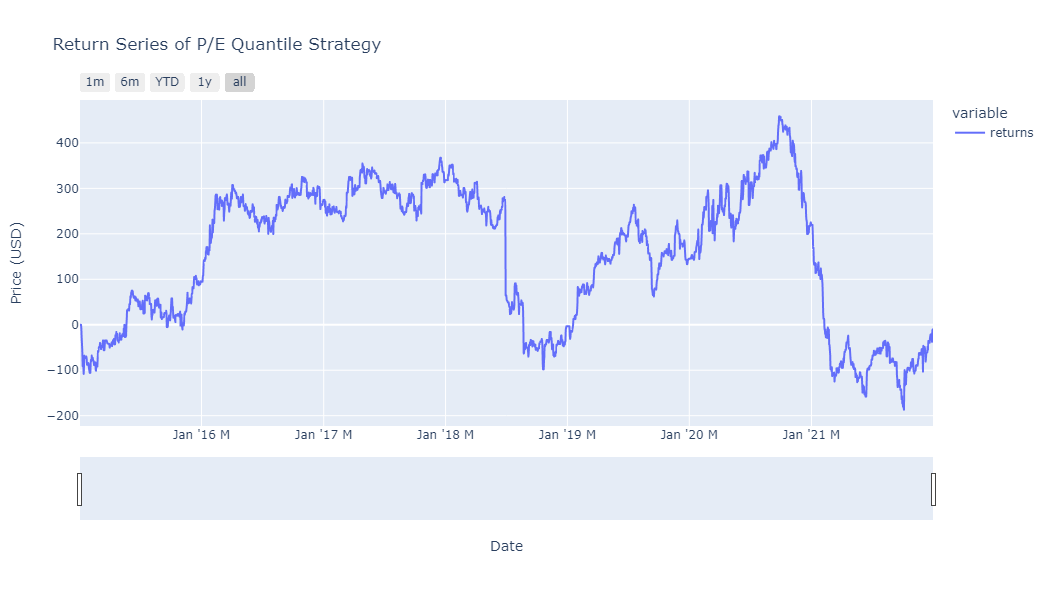

In [116]:
px_plot(
    pd.concat(returns_agg_lst),
    title='Return Series of P/E Quantile Strategy',
    labels={
        'value': 'Price (USD)',
        'dt': 'Date',
    },
)

Now, let's try quantile strategies based on the other financials:

In [177]:
%%time

def roi_runner_wrapper(date_range):
    return run_quantile_strat('roi', *date_range) 

def tdte_runner_wrapper(date_range):
    return run_quantile_strat('tot_debt_tot_equity', *date_range) 

def profit_margin_runner_wrapper(date_range):
    return run_quantile_strat('profit_margin', *date_range) 

def run_quantile_strat_for_ratio(ratio):
    with Pool() as p:
        results_agg = p.map(globals()[f'{ratio}_runner_wrapper'], date_ranges)
        
    returns_agg_lst = list()
    returns_offset = 0.
    for i, results_df in enumerate(results_agg):
        yr_returns = results_df.set_index('dt')['returns']
        yr_returns += returns_offset
        returns_agg_lst.append(yr_returns)
        returns_offset = yr_returns.iloc[-1]
    as_ser = pd.concat(returns_agg_lst)
    as_ser.index = pd.to_datetime(as_ser.index)
    as_ser.name = ratio
    return as_ser

results_tdte = run_quantile_strat_for_ratio('tdte')
results_roi = run_quantile_strat_for_ratio('roi')
results_pm = run_quantile_strat_for_ratio('profit_margin')
results_pe = run_quantile_strat_for_ratio('pe')

Using cache fp='./data/memoize/run_quantile_strat_e11c252_20230126.csv' to write results of function run_quantile_stratUsing cache fp='./data/memoize/run_quantile_strat_b6a6c00_20230126.csv' to write results of function run_quantile_stratUsing cache fp='./data/memoize/run_quantile_strat_c23545c_20230126.csv' to write results of function run_quantile_stratUsing cache fp='./data/memoize/run_quantile_strat_0cc52a0_20230126.csv' to write results of function run_quantile_stratUsing cache fp='./data/memoize/run_quantile_strat_e7bcb17_20230126.csv' to write results of function run_quantile_strat
Using cache fp='./data/memoize/run_quantile_strat_d1d724c_20230126.csv' to write results of function run_quantile_strat


Using cache fp='./data/memoize/run_quantile_strat_35f9a3a_20230126.csv' to write results of function run_quantile_strat
Using cached call from ./data/memoize/run_quantile_strat_e11c252_20230126.csvUsing cached call from ./data/memoize/run_quantile_strat_b6a6c00_20230126.csv
Using c

In [180]:
strat_results = pd.concat([
    results_tdte,
    results_roi,
    results_pm,
    results_pe,
], axis=1)
strat_results

,tdte,roi,profit_margin,pe
dt,,,,
2015-01-02,0.0000,0.0000,0.0000,0.0000
2015-01-03,0.0000,0.0000,0.0000,0.0000
2015-01-04,0.0000,0.0000,0.0000,0.0000
2015-01-05,0.0000,0.0000,0.0000,0.0000
2015-01-06,-13.2905,12.3233,-3.3854,-7.7330
...,...,...,...,...
2021-12-27,36.5432,467.0955,665.7398,-21.0621
2021-12-28,29.6053,471.8346,683.5047,-37.5079
2021-12-29,27.9091,467.8879,697.9153,-13.4206


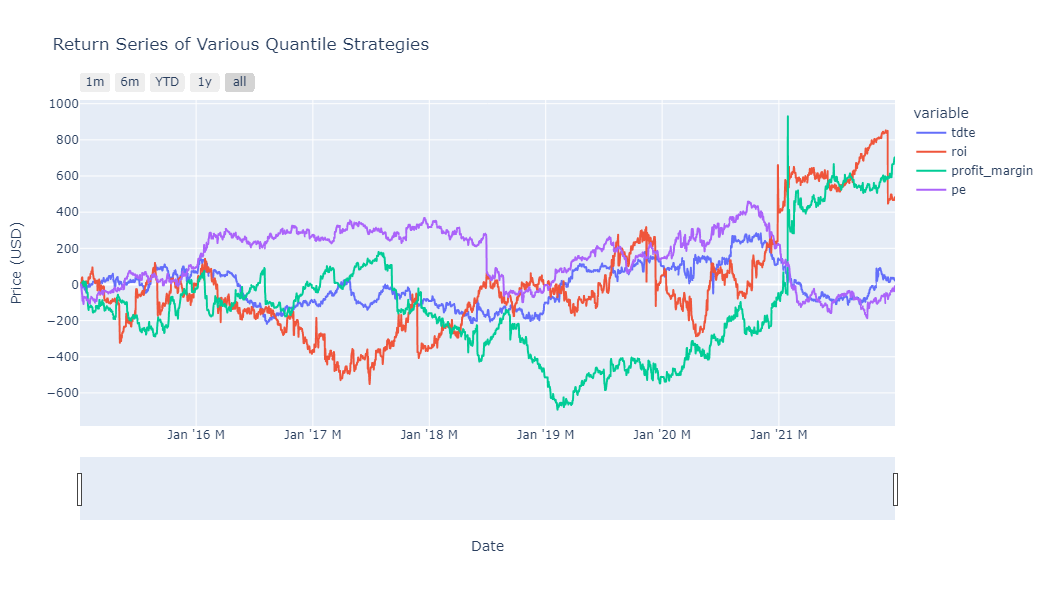

In [181]:
px_plot(
    strat_results,
    title='Return Series of Various Quantile Strategies',
    labels={
        'value': 'Price (USD)',
        'dt': 'Date',
    },
)

# Strategy Analysis

Are the strategies' return series correlated with each other? Are they correlated with Fama-French developed factors?

In [182]:
!wget -O ff_factors.zip https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_3_Factors_Daily_CSV.zip
!unzip -o ff_factors.zip
!head  Developed_3_Factors_Daily.csv

ff = pd.read_csv('Developed_3_Factors_Daily.csv', header=2).rename(columns={'Unnamed: 0': 'date'})
ff['date'] = pd.to_datetime(ff['date'], format='%Y%m%d')
ff.set_index('date', inplace=True)
ff.head()

--2023-01-26 22:33:40--  https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_3_Factors_Daily_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.136.60
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.136.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56554 (55K) [application/x-zip-compressed]
Saving to: ‘ff_factors.zip’

ff_factors.zip      100%[===================>]  55.23K  --.-KB/s    in 0.09s   

2023-01-26 22:33:40 (627 KB/s) - ‘ff_factors.zip’ saved [56554/56554]

Archive:  ff_factors.zip
  inflating: Developed_3_Factors_Daily.csv  
This file was created using the 202211 Bloomberg database.

Missing data are indicated by -99.99.



,Mkt-RF,SMB,HML,RF
19900702    ,0.69   ,-0.06   ,-0.33    ,0.03
19900703    ,0.18    ,0.07   ,-0.15    ,0.03
19900704    ,0.62   ,-0.17   ,-0.17    ,0.03


,Mkt-RF,SMB,HML,RF
date,,,,
1990-07-02,0.6900,-0.0600,-0.3300,0.0300
1990-07-03,0.1800,0.0700,-0.1500,0.0300
1990-07-04,0.6200,-0.1700,-0.1700,0.0300
1990-07-05,-0.7400,0.2900,0.1400,0.0300
1990-07-06,0.2000,-0.1700,0.0200,0.0300


In [183]:
daily_value = strat_results + 1e4
daily_value

,tdte,roi,profit_margin,pe
dt,,,,
2015-01-02,"10,000.0000","10,000.0000","10,000.0000","10,000.0000"
2015-01-03,"10,000.0000","10,000.0000","10,000.0000","10,000.0000"
2015-01-04,"10,000.0000","10,000.0000","10,000.0000","10,000.0000"
2015-01-05,"10,000.0000","10,000.0000","10,000.0000","10,000.0000"
2015-01-06,"9,986.7095","10,012.3233","9,996.6146","9,992.2670"
...,...,...,...,...
2021-12-27,"10,036.5432","10,467.0955","10,665.7398","9,978.9379"
2021-12-28,"10,029.6053","10,471.8346","10,683.5047","9,962.4921"
2021-12-29,"10,027.9091","10,467.8879","10,697.9153","9,986.5794"


In [191]:
daily_returns = daily_value - daily_value.shift(1)
daily_pct_returns = 100 * daily_returns / daily_value
daily_pct_returns = daily_pct_returns.merge(ff, how='left', left_index=True, right_index=True)
wk_returns = daily_value - daily_value.shift(7)
wk_pct_returns = 100 * wk_returns / daily_value
daily_pct_returns

,tdte,roi,profit_margin,pe,Mkt-RF,SMB,HML,RF
dt,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,-0.4700,-0.0700,0.2400,0.0000
2015-01-03,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
2015-01-04,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
2015-01-05,0.0000,0.0000,0.0000,0.0000,-1.7400,1.2100,-0.6700,0.0000
2015-01-06,-0.1331,0.1231,-0.0339,-0.0774,-1.1400,-0.1500,0.0100,0.0000
...,...,...,...,...,...,...,...,...
2021-12-27,0.0000,0.0000,0.0000,0.0000,0.8500,-0.5400,-0.0300,0.0000
2021-12-28,-0.0692,0.0453,0.1663,-0.1651,0.0400,0.0100,0.3900,0.0000
2021-12-29,-0.0169,-0.0377,0.1347,0.2412,0.1400,0.2700,0.1700,0.0000


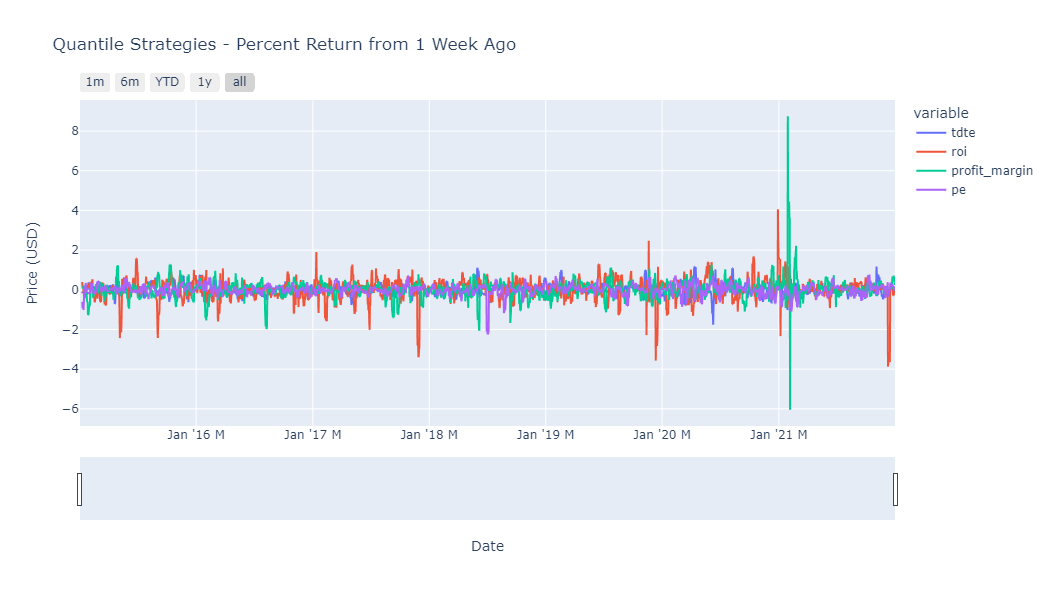

In [192]:
px_plot(
    wk_pct_returns,
    title='Quantile Strategies - Percent Return from 1 Week Ago',
    labels={
        'value': 'Price (USD)',
        'dt': 'Date',
    },
)

We see that strategies that trade quantiles in profit_margin and ROI are significantly more volatile than ones that trade P/E and debt/market cap quantiles.

Let's look at the strategy returns (daily %) correlations with each other, and with Fama-French factor returns.

                 tdte     roi  profit_margin      pe  Mkt-RF     SMB     HML  \
tdte           1.0000 -0.0157        -0.0116  0.0016 -0.0050  0.0516 -0.0099   
roi           -0.0157  1.0000         0.0448 -0.0194 -0.0005  0.0268 -0.0007   
profit_margin -0.0116  0.0448         1.0000  0.0457 -0.0322 -0.0072 -0.0098   
pe             0.0016 -0.0194         0.0457  1.0000 -0.0043 -0.0689 -0.0421   
Mkt-RF        -0.0050 -0.0005        -0.0322 -0.0043  1.0000 -0.4087  0.0721   
SMB            0.0516  0.0268        -0.0072 -0.0689 -0.4087  1.0000  0.0146   
HML           -0.0099 -0.0007        -0.0098 -0.0421  0.0721  0.0146  1.0000   
RF             0.0179  0.0113        -0.0300  0.0172 -0.0533 -0.0472 -0.0453   

                   RF  
tdte           0.0179  
roi            0.0113  
profit_margin -0.0300  
pe             0.0172  
Mkt-RF        -0.0533  
SMB           -0.0472  
HML           -0.0453  
RF             1.0000  


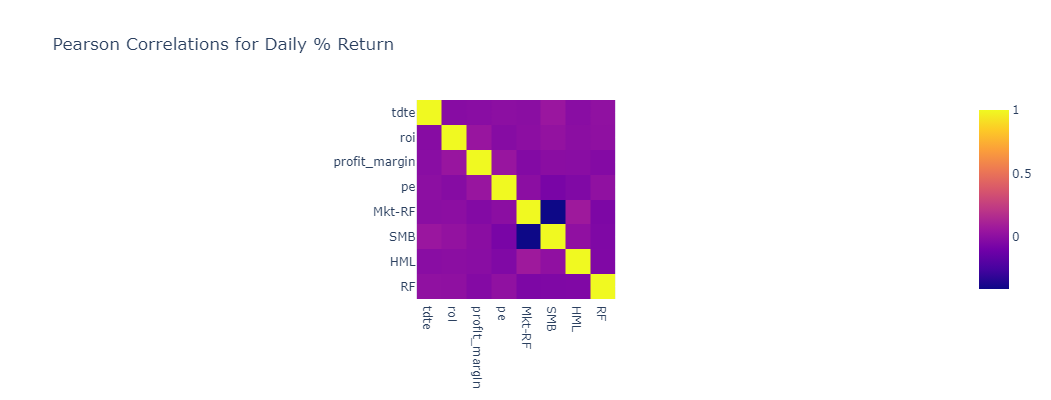

In [196]:
print(daily_pct_returns.corr())
px.imshow(
    daily_pct_returns.corr(),
    title='Pearson Correlations for Daily % Return',
    height=400, width=600,
)

There appears to be no correlation between daily % return and the FF factors.

Is there a correlation during bearish markets, such as during COVID-19 between 1/2019 and 11/2021?

                 tdte     roi  profit_margin      pe  Mkt-RF     SMB     HML  \
tdte           1.0000 -0.0001        -0.0114  0.0278 -0.0147  0.1006 -0.0505   
roi           -0.0001  1.0000         0.0517 -0.0069 -0.0014  0.0300  0.0045   
profit_margin -0.0114  0.0517         1.0000  0.0692 -0.0461  0.0086  0.0026   
pe             0.0278 -0.0069         0.0692  1.0000 -0.0450 -0.0628 -0.0710   
Mkt-RF        -0.0147 -0.0014        -0.0461 -0.0450  1.0000 -0.4261  0.1248   
SMB            0.1006  0.0300         0.0086 -0.0628 -0.4261  1.0000  0.0348   
HML           -0.0505  0.0045         0.0026 -0.0710  0.1248  0.0348  1.0000   
RF             0.0294 -0.0200        -0.0411  0.0718 -0.0633 -0.0597 -0.0466   

                   RF  
tdte           0.0294  
roi           -0.0200  
profit_margin -0.0411  
pe             0.0718  
Mkt-RF        -0.0633  
SMB           -0.0597  
HML           -0.0466  
RF             1.0000  


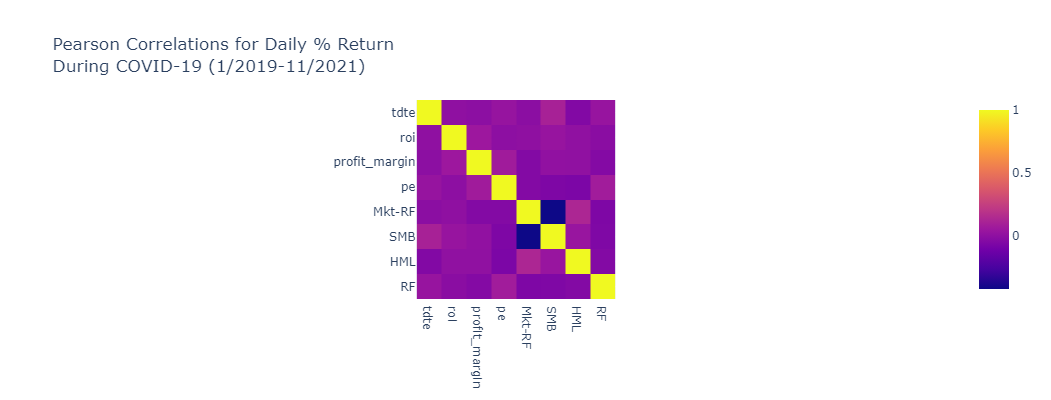

In [198]:
covid_returns = daily_pct_returns.loc['2019-01-01':'2021-11-01']
print(covid_returns.corr())
px.imshow(
    covid_returns.corr(),
    title='Pearson Correlations for Daily % Return<br>During COVID-19 (1/2019-11/2021)',
    height=400, width=600,
)

                 tdte     roi  profit_margin      pe
tdte           1.0000 -0.0892        -0.1122 -0.0210
roi           -0.0892  1.0000         0.0138  0.0205
profit_margin -0.1122  0.0138         1.0000  0.0800
pe            -0.0210  0.0205         0.0800  1.0000


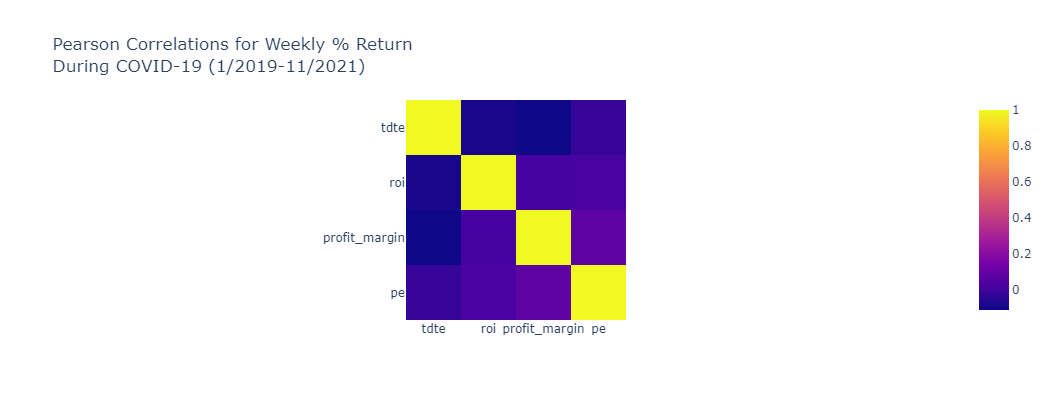

In [199]:
covid_returns_wk = wk_pct_returns.loc['2019-01-01':'2021-11-01']
print(covid_returns_wk.corr())
px.imshow(
    covid_returns_wk.corr(),
    title='Pearson Correlations for Weekly % Return<br>During COVID-19 (1/2019-11/2021)',
    height=400, width=600,
)

There is little to no correlation between these return series, even during the bearish pandemic market.